# Fraud Detection – Exploratory Data Analysis (EDA)

This notebook performs exploratory data analysis on a representative subset
of the transaction dataset (150,000 rows) used to train the Random Forest model.

The goal of this EDA is to:
- Understand feature distributions
- Explain model behavior
- Justify modeling decisions under extreme class imbalance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_context("notebook")

## Dataset Overview

We begin by loading a subset of the dataset for exploratory analysis.
EDA is performed on a manageable sample size to ensure faster iteration
while still capturing the overall data characteristics.

In [2]:
path = "../data/onlinefraud.csv"
df = pd.read_csv(path, nrows=150_000)

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Basic Dataset Information

This section examines the structure of the dataset, including:
- Number of rows and columns
- Data types of each feature
- Presence of missing values

In [3]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            150000 non-null  int64  
 1   type            150000 non-null  object 
 2   amount          150000 non-null  float64
 3   nameOrig        150000 non-null  object 
 4   oldbalanceOrg   150000 non-null  float64
 5   newbalanceOrig  150000 non-null  float64
 6   nameDest        150000 non-null  object 
 7   oldbalanceDest  150000 non-null  float64
 8   newbalanceDest  150000 non-null  float64
 9   isFraud         150000 non-null  int64  
 10  isFlaggedFraud  150000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 12.6+ MB


## Missing Values Analysis

We check for missing values to determine whether imputation or
feature removal is required before model training.

In [4]:
df.isnull().sum().sort_values(ascending=False)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

## Target Variable Distribution (Class Imbalance)

We analyze the distribution of the target variable (`isFraud`) to understand the extent of class imbalance.
This helps determine appropriate evaluation metrics and threshold strategies later.

In [5]:
df["isFraud"].value_counts()

isFraud
0    149871
1       129
Name: count, dtype: int64

In [6]:
df["isFraud"].value_counts(normalize=True) * 100

isFraud
0    99.914
1     0.086
Name: proportion, dtype: float64

## Visualization of Class Imbalance

A bar plot is used to visually highlight the imbalance between
fraudulent and legitimate transactions.

Text(0.5, 1.0, 'Fraud vs Non-Fraud Transactions')

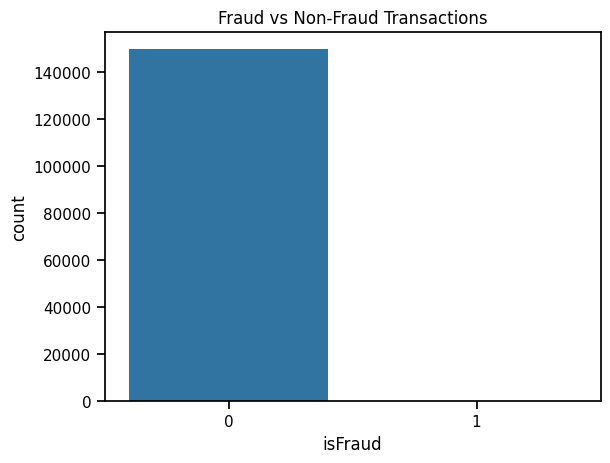

In [7]:
sns.countplot(x="isFraud", data=df)
plt.title("Fraud vs Non-Fraud Transactions")

- The target variable is **highly imbalanced**, with fraudulent transactions forming a very small fraction of the dataset.  
- This confirms that **accuracy alone is not a reliable evaluation metric**, and metrics such as precision, **recall**, F1-score, and ROC-AUC are more appropriate for this problem

## Numerical Feature Distributions

This section explores the distribution of key numerical features.
Understanding skewness and outliers helps in selecting
appropriate models and preprocessing techniques.

In [8]:
df["amount"].describe()

count    1.500000e+05
mean     1.789524e+05
std      3.401639e+05
min      3.200000e-01
25%      1.107369e+04
50%      6.099842e+04
75%      2.225778e+05
max      1.000000e+07
Name: amount, dtype: float64

- The transaction amount shows a wide range of values with a mean significantly higher than the median, indicating a right-skewed distribution
- This suggests the presence of extreme high-value transactions, which can disproportionately influence model training

Text(0.5, 1.0, 'Distribution of Transaction Amount (Log Scale)')

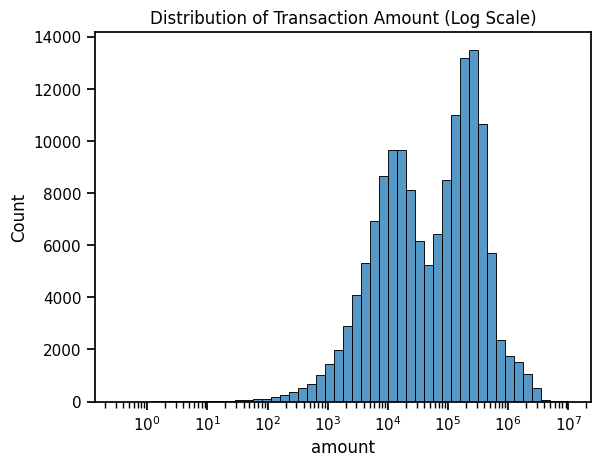

In [9]:
sns.histplot(df["amount"], bins=50, log_scale=True)
plt.title("Distribution of Transaction Amount (Log Scale)")

- The distribution of transaction amounts is heavily right-skewed.  
- Applying a logarithmic scale helps visualize both small and large transactions more clearly and highlights the presence of outliers.


## Feature Comparison by Class

We compare feature distributions between fraudulent and non-fraudulent
transactions to identify patterns that distinguish fraud behavior.

Text(0.5, 1.0, 'Transaction Amount by Fraud Status')

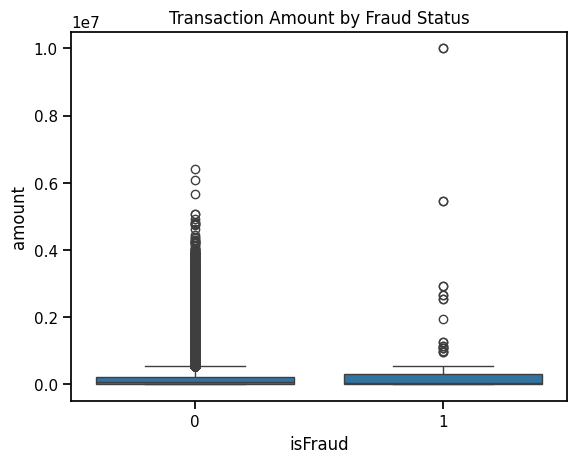

In [10]:
sns.boxplot(x="isFraud", y="amount", data=df)
plt.title("Transaction Amount by Fraud Status")

- Amount alone has weak discriminative power
- Fraud appears more frequently in unusual or extreme values, but not exclusively

Transaction Type vs Fraud

In [11]:
df.groupby("type")["isFraud"].sum()

type
CASH_IN      0
CASH_OUT    65
DEBIT        0
PAYMENT      0
TRANSFER    64
Name: isFraud, dtype: int64

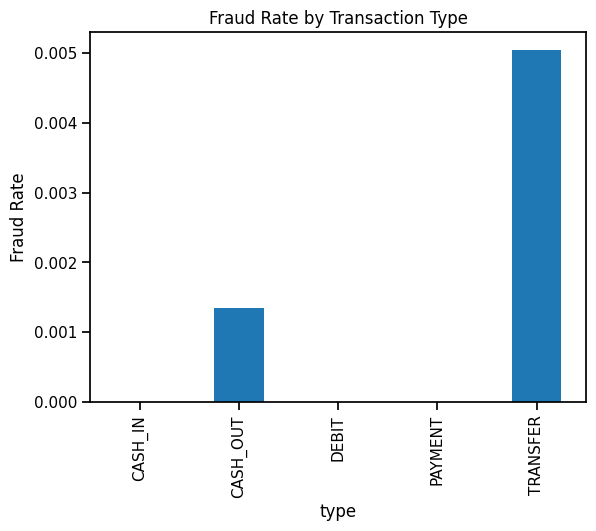

In [12]:
fraud_rate = (
    df.groupby("type")["isFraud"]
      .mean()
)

fraud_rate.plot(kind="bar")
plt.title("Fraud Rate by Transaction Type")
plt.ylabel("Fraud Rate")
plt.show()


- Fraudulent transactions occur exclusively in CASH_OUT and TRANSFER types, with no fraud observed in other transaction categories
- Transaction type is a highly informative categorical feature
- Feature encoding for `type` is critical for model performance

## Correlation Analysis

Correlation analysis helps identify relationships between numerical features
and the target variable, as well as potential multicollinearity.

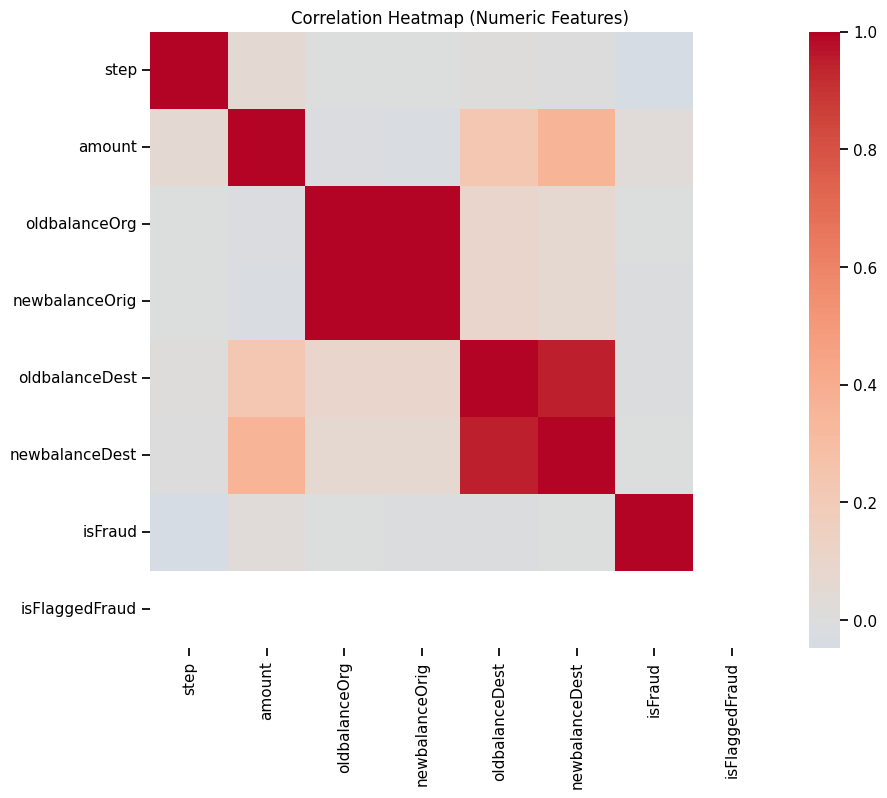

In [13]:
corr = df.select_dtypes(include="number").corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

- Old and new balances carry near-duplicate information.
- Linear correlation fails to capture fraud patterns.

## EDA Summary & Key Observations

Key insights from exploratory data analysis:

- The dataset is highly imbalanced, with fraud transactions forming a very small percentage.
- Transaction amounts are heavily right-skewed with extreme outliers.
- Fraudulent transactions exhibit distinct patterns in transaction type compared to non-fraudulent transactions.
- Class imbalance justifies the use of precision, recall, ROC-AUC, and threshold tuning.
- Tree-based models are expected to outperform linear models due to non-linear relationships.